# Глубинное обучение для текстовых данных, ФКН ВШЭ
## Домашнее задание 3: Уменьшение размеров модели
### Оценивание и штрафы

Максимально допустимая оценка за работу — __10 баллов__.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн 24.10.25 23:59__ \
__Жесткий дедлайн 26.10.25 23:59__

### О задании

В этом задании вам предстоит научиться решать задачу Named Entity Recognition (NER) на самом популярном датасете – [CoNLL-2003](https://paperswithcode.com/dataset/conll-2003). В вашем распоряжении будет предобученный BERT, который вам необходимо уменьшить с минимальными потерями в качестве до размера 20М параметров. Для этого вы самостоятельно реализуете факторизацию эмбеддингов, дистилляцию, шеринг параметров и так далее.

В этом задании вам придется проводить довольно много экспериментов, поэтому мы рекомендуем не писать весь код в тетрадке, а завести разные файлы для отдельных логических блоков и скомпоновать все в виде проекта. Это позволит вашему ноутбуку не разрастаться и сильно облегчит задачу и вам, и проверяющим. Так же постарайтесь логгировать все ваши эксперименты в wandb, чтобы ничего не потерялось.

### Оценивание
Оценка за это домашнее задание будет формироваться из оценки за __задания__ и за __отчет__, в котором от вас требуется написать о проделанной работе. За отчет можно получить до 2-х баллов, однако в случае отсутствия отчета баллы за соответствующие задания не будут ставиться. Задания делятся на две части: _номерные_ и _на выбор_. За _номерные_ можно получить в сумме 6 баллов, за задания _на выбор_ можно получить до 14. То есть за все дз можно получить 22 балла (но не радуйтесь рано, это не так просто). Все, что вы наберете свыше 10, будет считаться бонусами.


### О датасете

Named Entity Recognition – это задача классификации токенов по классам сущностей. В CoNLL-2003 для именования сущностей используется маркировка **BIO** (Beggining, Inside, Outside), в которой метки означают следующее:

- *B-{метка}* – начало сущности *{метка}*
- *I-{метка}* – продолжнение сущности *{метка}*
- *O* – не сущность

Существуют так же и другие способы маркировки, например, BILUO. Почитать о них можно [тут](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)) и [тут](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Всего в датасете есть 9 разных меток.
- O – слову не соответствует ни одна сущность.
- B-PER/I-PER – слово или набор слов соответстует определенному _человеку_.
- B-ORG/I-ORG – слово или набор слов соответстует определенной _организации_.
- B-LOC/I-LOC – слово или набор слов соответстует определенной _локации_.
- B-MISC/I-MISC – слово или набор слов соответстует сущности, которая не относится ни к одной из предыдущих. Например, национальность, произведение искусства, мероприятие и т.д.

Приступим!

Начнем с загрузки и предобработки датасета.

In [1]:
from datasets import load_dataset

dataset =  load_dataset("eriktks/conll2003", revision="convert/parquet")

dataset = dataset.remove_columns(["id", "pos_tags", "chunk_tags"])
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

In [2]:
dataset['train'][0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [3]:
label_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [4]:
words = dataset["train"][0]["tokens"]
labels = dataset["train"][0]["ner_tags"]

for i in range(len(words)):
    print(f'{words[i]}\t{label_names[labels[i]]}')

EU	B-ORG
rejects	O
German	B-MISC
call	O
to	O
boycott	O
British	B-MISC
lamb	O
.	O


### Предобработка

На протяжении всего домашнего задания мы будем использовать _cased_ версию BERT, то есть токенизатор будет учитывать регистр слов. Для задачи NER регистр важен, так как имена и названия организаций или предметов искусства часто пишутся с большой буквы, и будет глупо прятать от модели такую информацию.

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

При токенизации слова могут разделиться на несколько токенов (как слово `Fischler` из примера ниже), из-за чего появится несоответствие между числом токенов и меток. Это несоответствие нам придется устранить вручную.

In [6]:
example = dataset["train"][12]
words = example["tokens"]
tags = [label_names[t] for t in example["ner_tags"]]
tokenized_text = tokenizer(example["tokens"], is_split_into_words=True)

print('Слова: ', words)
print('Токены:', tokenized_text.tokens())
print('Метки:', tags)

Слова:  ['Only', 'France', 'and', 'Britain', 'backed', 'Fischler', "'s", 'proposal', '.']
Токены: ['[CLS]', 'Only', 'France', 'and', 'Britain', 'backed', 'Fi', '##sch', '##ler', "'", 's', 'proposal', '.', '[SEP]']
Метки: ['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


__Задание 1 (1 балл).__ Токенизируйте весь датасет и для каждого текста выравните токены с метками так, чтобы каждому токену соответствовала одна метка. При этом важно сохранить нотацию BIO. И не забудьте про специальные токены! Должно получиться что-то такое:

In [7]:
def tokenize_and_align_labels(example, tokenizer):
    tokenized_inputs = tokenizer(
        example["tokens"], 
        truncation=True, 
        is_split_into_words=True
    )

    original_labels = example["ner_tags"]
    word_ids = tokenized_inputs.word_ids()

    b_to_i_map = {}
    for i, label in enumerate(label_names):
        if label.startswith("B-"):
            i_label = "I-" + label[2:]
            if i_label in label_names:
                b_to_i_map[i] = label_names.index(i_label)

    new_labels = []
    previous_word_id = None
    for word_id in word_ids:
        # Для специальных токенов ([CLS], [SEP]) устанавливаем -100
        if word_id is None:
            new_labels.append(-100)
        # Для первого токена нового слова используем исходную метку
        elif word_id != previous_word_id:
            new_labels.append(original_labels[word_id])
        # Для последующих токенов того же слова
        else:
            original_label_id = original_labels[word_id]
            # Если исходная метка была B-, заменяем её на I-
            if original_label_id in b_to_i_map:
                new_labels.append(b_to_i_map[original_label_id])
            else:
                # Если метка была 'O' или уже 'I-', оставляем как есть
                new_labels.append(original_label_id)
        
        previous_word_id = word_id

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs
a = tokenize_and_align_labels(example, tokenizer)
print(a)
# print(*zip(, tokenized_text.tokens()), sep='\n')

{'input_ids': [101, 2809, 1699, 1105, 2855, 5534, 17355, 9022, 2879, 112, 188, 5835, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, 5, 0, 5, 0, 1, 2, 2, 0, 0, 0, 0, -100]}


In [8]:
aligned_labels = tokenize_and_align_labels(example, tokenizer)['labels']
tags = [label_names[t] if t > -1 else t for t in aligned_labels]
print("Выровненные метки:", aligned_labels)
print("Выровненные названия меток:", tags)

Выровненные метки: [-100, 0, 5, 0, 5, 0, 1, 2, 2, 0, 0, 0, 0, -100]
Выровненные названия меток: [-100, 'O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', -100]


In [9]:
dataset['train'][0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [10]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader

tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    fn_kwargs={"tokenizer": tokenizer},
    # remove_columns=dataset.column_names['train'],
    num_proc=6
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

batch_size = 8
dataloader = DataLoader(
    tokenized_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)


In [93]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

### Метрика

Для оценки качества NER обычно используют F1 меру с микро-усреднением. Мы загрузим ее из библиотеки `seqeval`. Функция `f1_score` принимает два 2d списка с правильными и предсказанными метками, записаными текстом, и возвращает для них значение F1. Вы можете использовать ее с параметрами по умолчанию.

In [12]:
# %pip install seqeval

In [13]:
from seqeval.metrics import f1_score

Особенность подсчета F1 для NER заключается в том, что в некоторых ситуациях неправильные ответы могут засчитываться как правильные. Например, если модель предсказала `['I-PER', 'I-PER']`, то мы можем догадаться, что на самом деле должно быть `['B-PER', 'I-PER']`, так как сущность не может начинаться с `I-`. Функция `f1_score` учитывает это и поэтому работает только с текстовыми представлениями меток.

### Модель

В качестве базовой модели мы возьмем `bert-base-cased`. Как вы понимаете, он не обучался на задачу NER. Поэтому прежде чем приступать к уменьшению размера BERT, его необходимо дообучить.

__Задание 2 (1 балл)__ Дообучите `bert-base-cased` на нашем датасете с помощью обычного fine-tuning. У вас должно получиться хотя бы 0.9 F1 на тестовой выборке. Заметьте, что чем выше качество большой модели, тем лучше будет работать дистиллированный ученик. Для обучения можно использовать `Trainer` из Hugging Face.

In [14]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label_names))

print('Число параметров:', sum(p.numel() for p in model.parameters()))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Число параметров: 107726601


In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    true_labels = [
        [label_names[l] for l in label if l != -100]
        for label in labels
    ]
    
    true_predictions = [
        [label_names[p] for p, l in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

In [16]:
import numpy as np
from transformers import Trainer, TrainingArguments, DataCollatorForTokenClassification
from seqeval.metrics import f1_score, precision_score, recall_score

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    save_strategy='epoch',
    report_to='tensorboard'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [17]:
trainer.evaluate()

/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


{'eval_loss': 2.028104066848755,
 'eval_model_preparation_time': 0.0041,
 'eval_precision': 0.007460520204366001,
 'eval_recall': 0.0432514304947829,
 'eval_f1': 0.01272592225798465,
 'eval_runtime': 10.3656,
 'eval_samples_per_second': 313.538,
 'eval_steps_per_second': 39.265}

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Precision,Recall,F1
1,0.110300,0.062381,0.004100,0.911562,0.936722,0.923971
2,0.017700,0.064062,0.004100,0.930298,0.945641,0.937907
3,0.015000,0.060913,0.004100,0.931615,0.949175,0.940313


TrainOutput(global_step=5268, training_loss=0.06636513072752302, metrics={'train_runtime': 426.6264, 'train_samples_per_second': 98.735, 'train_steps_per_second': 12.348, 'total_flos': 920771584279074.0, 'train_loss': 0.06636513072752302, 'epoch': 3.0})

### Факторизация матрицы эмбеддингов

Можно заметить, что на данный момент матрица эмбеддингов занимает $V \cdot H = 28996 \cdot 768 = 22.268.928$ параметров. Это aж пятая часть от всей модели! Давайте попробуем что-то с этим сделать. В модели [ALBERT](https://arxiv.org/pdf/1909.11942.pdf) предлагается факторизовать матрицу эмбеддингов в произведение двух небольших матриц. Таким образом, параметры эмбеддингов будут содержать $V \cdot E + E \cdot H$ элементов, что гораздо меньше $V \cdot H$, если $H \gg E$. Авторы выбирают $E = 128$, однако ничего не мешает нам взять любое другое значение. Например, выбрав $H = 64$, мы уменьшим число параметров примерно на 20М.

__Задание 3 (1 балл).__ Напишите класс-обертку над слоем эмбеддингов, который реализует факторизацию на две матрицы, и дообучите факторизованную модель. Заметьте, обе матрицы можно инициализировать с помощью SVD разложения, чтобы начальное приближение было хорошим. Это сэкономит очень много времени на дообучении. С рангом разложения $H = 64$ у вас должно получиться F1 больше 0.87.

In [20]:
model.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [21]:
import torch
W = model.bert.embeddings.word_embeddings.weight
u, s, v = torch.linalg.svd(W, full_matrices=False)


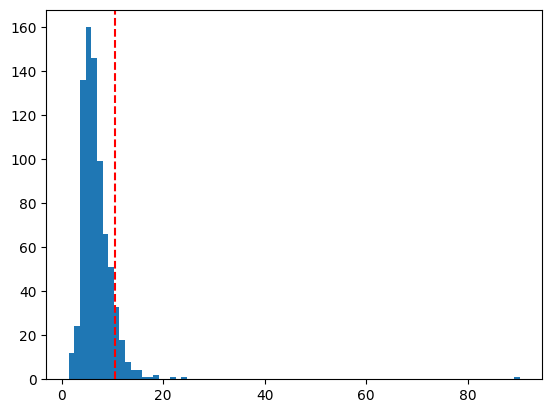

In [22]:
import matplotlib.pyplot as plt
plt.hist(s[:].detach().cpu().numpy(), bins=80)
plt.axvline(s[64].detach().cpu().numpy(), color='red', linestyle='--')
plt.show()

In [23]:
s[64]

tensor(10.4977, device='cuda:0', grad_fn=<SelectBackward0>)

In [24]:
s[64:].sum() / s.sum()

tensor(0.8298, device='cuda:0', grad_fn=<DivBackward0>)

In [25]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [26]:
import torch.nn as nn
import torch
class EmbeddingWrapper(nn.Module):
    def __init__(self, big_embeddings: nn.Embedding, rank: int):
        super().__init__()
        vocab_size = big_embeddings.num_embeddings
        output_size = big_embeddings.embedding_dim

        # init using SVD
        UT, S, V = torch.linalg.svd(big_embeddings.weight, full_matrices=False)
        s = torch.sqrt(S[:rank])
        A = UT[:, :rank] * s
        B = torch.diag(s) @ V[:rank, :]

        # print(A.shape)
        # print(B.shape)
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=rank, padding_idx=big_embeddings.padding_idx)
        self.embedding.weight.data = A

        self.projection = nn.Linear(in_features=rank, out_features=output_size, bias=False)
        self.projection.weight.data = B.T

    def forward(self, x):
        x = self.embedding(x)
        x = self.projection(x)
        return x

In [27]:
# model.bert.embeddings.word_embeddings = original_embeddings

In [28]:
rank = 64
original_embeddings = model.bert.embeddings.word_embeddings
factorized_embeddings = EmbeddingWrapper(original_embeddings, rank=rank)
model.bert.embeddings.word_embeddings = factorized_embeddings

##### print(f'Число параметров: {sum(p.numel() for p in model.parameters()) / 1e6:0.2f}M', )

In [30]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    save_strategy='epoch',
    report_to='tensorboard'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [31]:
trainer.evaluate()

{'eval_loss': 1.1365939378738403,
 'eval_model_preparation_time': 0.0078,
 'eval_precision': 0.4466243508366994,
 'eval_recall': 0.13025917199596096,
 'eval_f1': 0.20169381107491857,
 'eval_runtime': 7.0967,
 'eval_samples_per_second': 457.957,
 'eval_steps_per_second': 57.35}

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Precision,Recall,F1
1,0.074600,0.097016,0.007800,0.888616,0.912992,0.900639
2,0.021300,0.104698,0.007800,0.908805,0.924100,0.916389
3,0.042300,0.105277,0.007800,0.916846,0.931505,0.924117


TrainOutput(global_step=5268, training_loss=0.062418800225780516, metrics={'train_runtime': 385.922, 'train_samples_per_second': 109.149, 'train_steps_per_second': 13.65, 'total_flos': 921303634723362.0, 'train_loss': 0.062418800225780516, 'epoch': 3.0})

### Дистилляция знаний

Дистилляция знаний – это парадигма обучения, в которой знания модели-учителя дистиллируются в модель-ученика. Учеником может быть произвольная модель меньшего размера, решающая ту же задачу, однако обычно ученик имеет ту же архитектуру, что и учитель. При дистилляции используются два функционала ошибки:

1. Стандартная кросс-энтропия.
1. Функция, задающая расстояние между распределениями предсказаний учителя и ученика. Чаще всего используют KL-дивергенцию.

Для того, чтобы распределение предсказаний учителя не было вырожденным, к softmax добавляют температуру больше 1, например, 2 или 5.   
__Важно:__ при делении логитов на температуру значения градиентов уменьшаются в $\tau^2$ раз (проверьте это!). Поэтому для возвращения их в изначальный масштаб ошибку надо домножить на $\tau^2$. Подробнее об этом можно почитать в разделе 2.1 [оригинальной статьи](https://arxiv.org/pdf/1503.02531).

<img src="https://intellabs.github.io/distiller/imgs/knowledge_distillation.png" width="800">

__Задание 4 (3 балла).__ Реализуйте метод дистилляции знаний, изображенный на картинке. Для подсчета ошибки между предсказаниями ученика и учителя используйте KL-дивергенцию [`nn.KLDivLoss(reduction="batchmean")`](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html) (обратите внимание на вормат ее входов). Для получения итоговой ошибки суммируйте мягкую ошибку с жесткой.   
В качестве учителя используйте дообученный BERT из задания 2. В качестве ученика возьмите необученную модель с размером __не больше 20M__ параметров. Вы можете использовать факторизацию матрицы эмбеддингов для уменьшения числа параметров. Если вы все сделали правильно, то на тестовой выборке вы должны получить значение F1 не меньше 0.7. Вам должно хватить примерно 20к итераций обучения для этого. Если у вас что-то не получается, то можно ориентироваться на статью про [DistilBERT](https://arxiv.org/abs/1910.01108) и на [эту статью](https://www.researchgate.net/publication/375758425_Knowledge_Distillation_Scheme_for_Named_Entity_Recognition_Model_Based_on_BERT).

__Важно:__
* Не забывайте добавлять _warmup_ при обучении ученика.
* Не забывайте переводить учителя в режим _eval_.

#### Prepare teacher

In [43]:
model.bert.embeddings.word_embeddings = original_embeddings
teacher = model

In [44]:
teacher

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [46]:
for param in teacher.parameters():
    param.requires_grad_(False)

In [48]:
for param in teacher.parameters():
    assert param.requires_grad == False

#### Student

In [57]:
teacher

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [56]:
3072 / 8

384.0

In [142]:
from transformers import BertConfig, BertForTokenClassification

student_config = BertConfig(
    vocab_size=28996,
    hidden_size=768//2,
    num_hidden_layers=8,
    num_attention_heads=8,
    intermediate_size=3072//2,
    num_labels=9,
)

student = BertForTokenClassification(student_config)

big_embeddings = student.bert.embeddings.word_embeddings
smol_embeddings = EmbeddingWrapper(big_embeddings, rank=64)
student.bert.embeddings.word_embeddings = smol_embeddings

total_params = sum(p.numel() for p in student.parameters())
print(f"Student model created with {total_params:,} parameters.")
print(f"Student model configuration: {student_config}")

Student model created with 16,277,641 parameters.
Student model configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



In [134]:
student

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): EmbeddingWrapper(
        (embedding): Embedding(28996, 64, padding_idx=0)
        (projection): Linear(in_features=64, out_features=384, bias=False)
      )
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-7): 8 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
           

In [135]:
teacher

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

#### DistillationTrainer

In [143]:
from torch.nn import functional as F
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, temperature=2.0, alpha=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.teacher_model.eval()
        self.temperature = temperature
        self.alpha = alpha

    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        # print(inputs.keys())
        # print(*map(lambda x: x.shape, inputs.values()))
        # print(student_logits.shape, teacher_logits.shape)
        
        # Reshape for cross_entropy
        num_classes = student_logits.shape[-1]
        logits_for_loss = student_logits.view(-1, num_classes)
        labels_for_loss = inputs['labels'].view(-1)

        # hard loss
        hard_loss = F.cross_entropy(logits_for_loss, labels_for_loss)

        # soft loss
        soft_labels = F.softmax(teacher_logits / self.temperature, dim=-1)
        # soft predictions (log-probs for KL loss)
        soft_predictions = F.log_softmax(student_logits / self.temperature, dim=-1)

        distillation_loss = F.kl_div(soft_predictions, soft_labels, reduction='batchmean') * (self.temperature ** 2)
        total_loss = self.alpha * distillation_loss + (1 - self.alpha) * hard_loss

        return (total_loss, student_outputs) if return_outputs else total_loss

In [137]:
from pprint import pprint
for x in tokenized_dataset['train']:
    pprint(x)
    break

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101,
               7270,
               22961,
               1528,
               1840,
               1106,
               21423,
               1418,
               2495,
               12913,
               119,
               102],
 'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'tokens': ['EU',
            'rejects',
            'German',
            'call',
            'to',
            'boycott',
            'British',
            'lamb',
            '.']}


#### Training

In [144]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    warmup_steps=1000,
    dataloader_num_workers=6,
    run_name="Distillation",
    num_train_epochs=12,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=10,
    logging_first_step=True,
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    eval_on_start=True,
    save_strategy='epoch',
    # eval_steps=5_000,
    report_to='tensorboard'
)

trainer = DistillationTrainer(
    teacher_model=teacher,
    temperature=2.0,
    alpha=0.5,
    model=student,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
# add warmup stage to student
# put teacher in eval and train two model together?

In [145]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
0,No log,163.293198,0.010612,0.095254,0.019096
1,23.381000,20.625509,0.386037,0.488556,0.431288
2,14.490600,15.528271,0.561052,0.635645,0.596023
3,11.676500,13.166449,0.638567,0.704981,0.670133
4,12.344300,11.820036,0.652734,0.733255,0.690655
5,8.968400,11.365520,0.694972,0.763043,0.727419
6,6.119100,11.017979,0.711228,0.771794,0.740274
7,3.545800,11.024203,0.726699,0.775496,0.750305
8,3.037700,11.046603,0.718279,0.778357,0.747113
9,3.505200,11.161644,0.720254,0.783406,0.750504


TrainOutput(global_step=21072, training_loss=10.122965477005314, metrics={'train_runtime': 860.392, 'train_samples_per_second': 195.832, 'train_steps_per_second': 24.491, 'total_flos': 616680694393434.0, 'train_loss': 10.122965477005314, 'epoch': 12.0})

# Задания на выбор

Как вы понимаете, есть еще довольно много разных способов уменьшить обученную модель. В этой секции вам предлагается реализовать разные техники на выбор. За каждую из них можно получить разное количество балов в зависимости от сложности. Успешность реализации будет оцениваться как по коду, так и по качеству на тестовой выборке. Все баллы за это дз, которые вы наберете сверх 10, будут считаться бонусными.   
В задании 4 вы обучали модель с ограничением числа параметров в 20М. При реализации техник из этой секции придерживайтесь такого же ограничения. Это позволит честно сравнивать методы между собой и делать правильные выводы. Напишите в отчете обо всем, что вы попробовали.

* __Шеринг весов (1 балл).__ В модификации BERT [ALBERT](https://arxiv.org/pdf/1909.11942.pdf) помимо факторизации эмбеддингов предлагается шерить веса между слоями. То есть разные слои используют одни и те же веса. Такая техника эвивалентна применению одного и того же слоя несколько раз. Она позволяет в несколько раз уменьшить число параметров и не сильно потерять в качестве.
* __Факторизация промежуточных слоев (1 балл).__ Если можно факторизовать матрицу эмбеддингов, то и все остальное тоже можно. Для факторизации слоев существует много разных подходов и выбрать какой-то один сложно. Вы можете вдохновляться [этим списком](https://lechnowak.com/posts/neural-network-low-rank-factorization-techniques/), найти в интернете что-то другое или придумать метод самостоятельно. В любом случае в отчете обоснуйте, почему вы решили сделать так как сделали.
* __Приближение промежуточных слоев (2 балла).__ Мы обсуждали, что помимо приближения выходов модели ученика к выходам модели учителя, можно приближать выходы промежуточных слоев. В [этой работе](https://www.researchgate.net/publication/375758425_Knowledge_Distillation_Scheme_for_Named_Entity_Recognition_Model_Based_on_BERT) подробно написано, как это можно сделать.
* __Прунинг (4 балла).__ В методе [SparseGPT](https://arxiv.org/abs/2301.00774) предлагается подход, удаляющий веса модели один раз после обучения. При этом оказывается возможным удалить до половины всех весов без потери в качестве. Математика, стоящаяя за техникой, довольно сложная, однако общий подход простой – будем удалять веса в каждом слое по отдельности, при удалении части весов слоя, остальные веса будут перенастраиваться так, чтобы общий выход слоя не изменился.
* __Удаление голов (6 баллов).__ В данный момент мы используем все головы внимания, но ряд исследований показывает, что большинство из них можно выбросить без потери качества. В этой [статье](https://arxiv.org/pdf/1905.09418.pdf) предлагается подход, который добавляет гейты к механизму внимания, которые регулируют, какие головы участвуют в слое, а какие – нет. В процессе обучения гейты настраиваются так, чтобы большинство голов не использовалась. В конце обучения неиспользуемые головы можно удалить. За это задание дается много баллов, потому что в методе довольно сложная математика и подход плохо заводится. Если вы решитесь потратить на него свои силы, то в случае неудачи мы дадим промежуточные баллы, опираясь на отчет.   
__Совет:__ во время обучения внимательно следите за поведением гейтов. Если вы все сделали правильно, то они должны зануляться. Однако зануляются они не всегда сразу, им надо дать время и обучать модель подольше.

In [ ]:
# 1) add weight factorization( check for something more sophisticated then sumple wrappers)
# 2) add attention loss and adaptive soft/hard loss parameter
# 3) weight sharing? read ALBERT and see whats up with that

### Weight sharing

In [146]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

Я хочу попробовать арзитектуру предложенную в ALBERT полностью, поэтому обучу модель с факторизацией эмбедингов отдельно, чтобы появилась точка отсчета. Потом добавлю шеринг параметров attention, что привело к лучшим результатам в статье, потом еще больше уменьшу модель через шеринг параметров FFN.

In [151]:
model = AutoModelForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label_names))
print(f'Число параметров: {sum(p.numel() for p in model.parameters()):,}')

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Число параметров: 107,726,601


In [152]:
rank = 128
original_embeddings = model.bert.embeddings.word_embeddings
factorized_embeddings = EmbeddingWrapper(original_embeddings, rank=rank)
model.bert.embeddings.word_embeddings = factorized_embeddings
print(f'Число параметров: {sum(p.numel() for p in model.parameters()):,}')

Число параметров: 89,267,465


In [154]:
import numpy as np
from transformers import Trainer, TrainingArguments, DataCollatorForTokenClassification
from seqeval.metrics import f1_score, precision_score, recall_score

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    weight_decay=0.1,
    bf16=True,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    save_strategy='epoch',
    eval_on_start=True,
    report_to='tensorboard'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [155]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
0,No log,2.323120,0.011133,0.058061,0.018683
1,0.102600,0.090316,0.878164,0.910973,0.894267
2,0.024200,0.089452,0.913470,0.925614,0.919502
3,0.036500,0.087978,0.916061,0.933019,0.924462


TrainOutput(global_step=5268, training_loss=0.09656790837620073, metrics={'train_runtime': 487.0179, 'train_samples_per_second': 86.492, 'train_steps_per_second': 10.817, 'total_flos': 921835685167650.0, 'train_loss': 0.09656790837620073, 'epoch': 3.0})

#### Attention sharing

In [163]:
model = AutoModelForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label_names))
print(f'Число параметров base: {sum(p.numel() for p in model.parameters()):,}')

rank = 128
original_embeddings = model.bert.embeddings.word_embeddings
factorized_embeddings = EmbeddingWrapper(original_embeddings, rank=rank)
model.bert.embeddings.word_embeddings = factorized_embeddings
print(f'Число параметров embedding factorized: {sum(p.numel() for p in model.parameters()):,}')

shared_attention = model.bert.encoder.layer[0].attention

for i in range(1, len(model.bert.encoder.layer)):
    model.bert.encoder.layer[i].attention = shared_attention

print(f'Число параметров shared attention: {sum(p.numel() for p in model.parameters()):,}')

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Число параметров base: 107,726,601
Число параметров embedding factorized: 89,267,465
Число параметров shared attention: 63,264,521


In [165]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    warmup_steps=1000,
    dataloader_num_workers=10,
    weight_decay=0.1,
    bf16=True,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    save_strategy='epoch',
    eval_on_start=True,
    report_to='tensorboard',
    save_safetensors=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [166]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
0,No log,2.161927,0.003429,0.039212,0.006307
1,0.165700,0.204727,0.683708,0.771962,0.725160
2,0.085900,0.115697,0.820622,0.874621,0.846762
3,0.051400,0.116228,0.852483,0.892797,0.872174


TrainOutput(global_step=5268, training_loss=0.22283507705062922, metrics={'train_runtime': 423.0602, 'train_samples_per_second': 99.567, 'train_steps_per_second': 12.452, 'total_flos': 640364373562914.0, 'train_loss': 0.22283507705062922, 'epoch': 3.0})

#### FFN & attention weights sharing 

In [167]:
model.bert.encoder

BertEncoder(
  (layer): ModuleList(
    (0-11): 12 x BertLayer(
      (attention): BertAttention(
        (self): BertSdpaSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [168]:
model = AutoModelForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label_names))
print(f'Число параметров base: {sum(p.numel() for p in model.parameters()):,}')

rank = 128
original_embeddings = model.bert.embeddings.word_embeddings
factorized_embeddings = EmbeddingWrapper(original_embeddings, rank=rank)
model.bert.embeddings.word_embeddings = factorized_embeddings
print(f'Число параметров embedding factorized: {sum(p.numel() for p in model.parameters()):,}')

for i in range(1, len(model.bert.encoder.layer)):
    model.bert.encoder.layer[i].attention = model.bert.encoder.layer[0].attention
    model.bert.encoder.layer[i].intermediate = model.bert.encoder.layer[0].intermediate
    model.bert.encoder.layer[i].output = model.bert.encoder.layer[0].output

print(f'Число параметров shared everything: {sum(p.numel() for p in model.parameters()):,}')

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Число параметров base: 107,726,601
Число параметров embedding factorized: 89,267,465
Число параметров shared everything: 11,300,873


In [169]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    warmup_steps=1000,
    dataloader_num_workers=10,
    weight_decay=0.1,
    bf16=True,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    save_strategy='epoch',
    eval_on_start=True,
    report_to='tensorboard',
    save_safetensors=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
0,No log,2.156683,0.002200,0.001346,0.001670
1,0.184100,0.198619,0.681296,0.768092,0.722095
2,0.087300,0.138094,0.798362,0.852911,0.824736
3,0.056500,0.128125,0.824920,0.869068,0.846419


TrainOutput(global_step=5268, training_loss=0.22478571551411372, metrics={'train_runtime': 333.8479, 'train_samples_per_second': 126.174, 'train_steps_per_second': 15.78, 'total_flos': 77878981204002.0, 'train_loss': 0.22478571551411372, 'epoch': 3.0})

Получается, что оставив меньше 1/10 модели, можно все равно иметь не худший перформанс.

### Итоги

В этом ноутбуке все эксперименты были поставленны наугад и с правильными гиперараметрами методы показали бы другие результаты. Однако, я не думаю, что по моей работе в любом случае можно было бы судить про методы, я бы лучше доверял ALBERT, где показывается, что результаты почти не меняются от шеринга весов attention.

Спасибо за эту HW! Было очень интересно порезать разными способами BERT. 